### **Esercizio 11.2**

##### **Analisi del problema**

In questo esercizio continuiremo ad esplorare la costruzione e l'utilizzo di una rete neurale profonda (deep neural network). La funzione da fittare ora è un polinomio del terzo ordine:

$$
f(x)=4-3x-2x^2+3x^3 \hspace{0.6cm}  x \in [-1,1]
$$

In accordo con la complessità della nuova funzione, dovremo aumentare di conseguenza la complesità della NN, modificando:
- il numero di layers
- il numero di neuroni per layer
- la funzione di attivazione 
- optimizer

Iniziando dalle funzioni di attivazione, ho fatto un po' di prove e tra tutte quella che ha in assoluto performato meglio è ReLU, seguita da ELU che ha prodotto risultati leggermente peggiori.

Mentre per l'optimizer, testando quelli proposti (<i>sgd, adagrad, adadelta, adam, adamax e nadam</i>), non ho trovato una grande differenza nella loro performance, tranne per <i>adagrad</i> e <i>adadelta</i> che forniscono decisamente una loss peggiore. Dunque tra tutti quelli che ottengono buoni risultati, ho deciso di utilizzare <i>adam</i> che in tutte le run che ho fatto è quello che convergeva più velocemente in una decina di epoche (a fissata complessità della NN e campione di dati di training). Si veda in fondo alla pagina l'andamento della loss in questa configurazione.

##### **Definizione dei parametri e generazione dei dati** 
Iniziamo definendo i parametri della nostra NN. Da notare come rispetto all'esercizio precedente ho incrementato la dimensione  campione di test, data la difficoltà della NN di seguire esattamente la funzione nei cambi repentini di pendenza (massimi, minimi, punti di flesso). 

Successivamente ho plottato la funzione e l'insieme dei punti di validazione, generati partendo da $ N_{valid} \ \ x_{valid} \in [-1,1] $ calcolando poi la funzioni in queste ascisse aggiungendo un rumore gaussiano ($\sigma=0.1$).

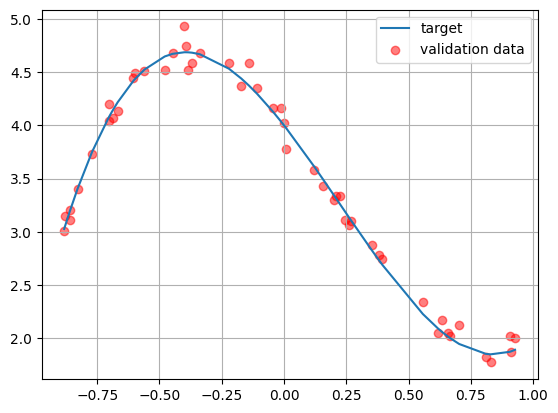

In [25]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Activation
from keras import backend as K
from keras.utils import get_custom_objects

N_train = 3000
N_valid = 50
N_epochs = 30
sigma = 0.1 # noise standard deviation
def f(x, a=4, b=-3, c=-2, d=3):
    return a + b*x + c*(x)**2 + d*(x)**3


np.random.seed(0)
tf.random.set_seed(0)
x_train = np.random.uniform(-1, 1, N_train)
x_valid = np.random.uniform(-1, 1, N_valid) 
x_valid.sort()
y_target = f(x=x_valid)

y_train = np.random.normal(f(x=x_train), sigma)
y_valid = np.random.normal(f(x=x_valid), sigma)

plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data', alpha=0.5)
plt.legend()
plt.grid(True)
plt.show()

##### **Definizione della rete neurale e allenamento**
Costruisco ora la mia rete neurale. Il modello è sequenziale:
- ottimo per imparare a costruire una NN affiancando gli strati in modo lineare 
- supporta reti con un singolo input e un singolo output

Essa utilizza tre livelli completamente connessi:
- il primo layer da 32 neuroni che riceve l'input unidimenionale dell'intera rete;
- il secondo livello è formato ancora da 32 neuroni;
- il terzo layer ha un singolo neurone di output;
- l'output di ogni livello passa attraverso la funzione di attivazione ReLU (Rectified Linear Unit). 

Il modello è compilato con l'optimizer "adam" definito nella documentazione di keras come: "*Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments*". Segue successivamente un riassunto del modello creato.

In [26]:
model = Sequential()

# activation: relu, elu, exponential, sigmoid, softmax, softplus, softsign, tanh
model.add(Input(shape=(1,)))  # input esplicito
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='adam', loss='mse', metrics=['mse']) 
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

Ora addestro il modello, fornisco al neurone l'insieme delle coppie di addestramento $x_{train},\ y_{train}$ da cui l'ottimizzatore troverà i pesi migliori per minimizzare la loss function: 
$$ mse = \text{mean square error}= \frac{1}{N} \sum_{i=1}^N \left| y_i^{out}-y_i^{lab}\right|^2$$

In [27]:
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=N_epochs,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10.3100 - mse: 10.3100 - val_loss: 2.3491 - val_mse: 2.3491
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5218 - mse: 1.5218 - val_loss: 0.6233 - val_mse: 0.6233
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6716 - mse: 0.6716 - val_loss: 0.2768 - val_mse: 0.2768
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3121 - mse: 0.3121 - val_loss: 0.1004 - val_mse: 0.1004
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1272 - mse: 0.1272 - val_loss: 0.0445 - val_mse: 0.0445
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0628 - mse: 0.0628 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227 - mse

##### **Analisi della rete**
Ora che il modello è allenato, usiamo il campione di validazione e alcuni punti della curva per valutare il nostro modello usando dei dati che ha già visto e alcuni che non ha visto.

In [28]:
# return weights and biases
# model.get_weights()

print("=== RESULTS ===")
print()
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=1)
print("TEST DATA EVAL")
print('Test loss:', score[0])
print()
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)
print("EXACT CURVE EVAL")
print('Test loss:', score[0])

=== RESULTS ===

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0097 - mse: 0.0097
TEST DATA EVAL
Test loss: 0.009549470618367195

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.0489e-04 - mse: 7.0489e-04
EXACT CURVE EVAL
Test loss: 0.0006832805811427534


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


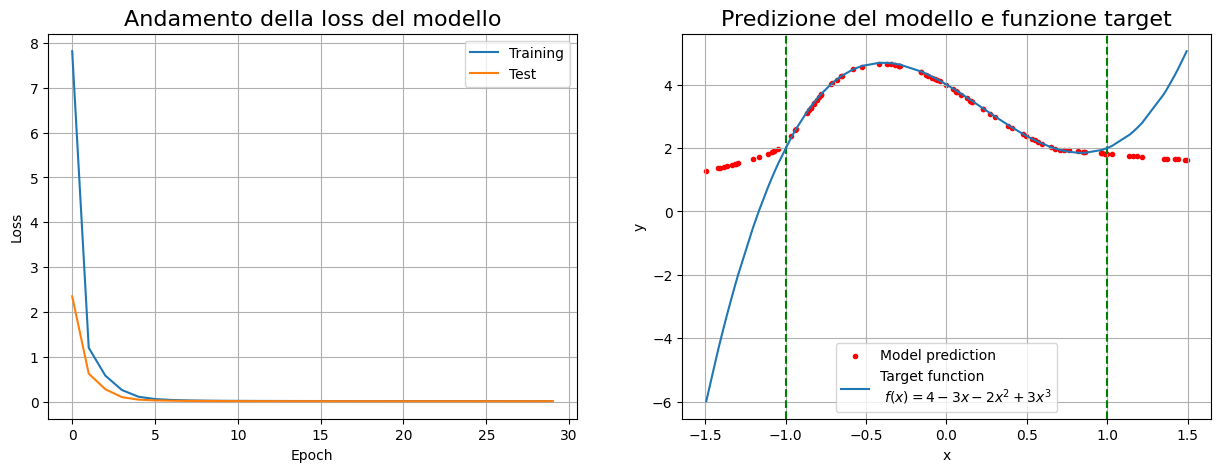

In [29]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training')        # → curva del training set
plt.plot(history.history['val_loss'], label= 'Test')    # → curva del validation (test) se
plt.title('Andamento della loss del modello', fontsize = 16)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# generate predictions
x_predicted = np.random.uniform(-1.5, 1.5, 100) 
y_predicted = model.predict(x_predicted)

plt.subplot(1,2,2)
plt.scatter(x_predicted, y_predicted, marker = ".", color='r', label = "Model prediction")
x_predicted.sort()
y_target_ext = f(x_predicted)
plt.axvline(1., color = 'g', linestyle = '--')
plt.axvline(-1., color = 'g', linestyle = '--')
plt.plot(x_predicted, y_target_ext, label = "Target function\n $f(x) = 4 -3x - 2x^2 + 3x^3$")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predizione del modello e funzione target", fontsize = 16)
plt.grid(True)
plt.legend()
plt.show()

<div style="width: 48%; float: left;">

Sulla sinistra possiamo osservare l'andamento della loss in funzione delle epoche di allenamento, sia per i dati di <font color="#1FA0FF">training</font> che per quelli di <font color="#FFAE00">validazione</font>. Ho lasciato 30 epoche anche se dal grafico capiamo subito che ne basterebbero appena 10 per far convergere il modello.

Si nota come la loss sui dati di training sia leggermente più alta rispetto a quella sui dati di validazione. Questo comportamento suggerisce che il modello sta generalizzando correttamente, senza adattarsi eccessivamente al rumore gaussiano presente nei dati.
  
Inoltre, la stabilità delle due curve indica che non è in atto overfitting: il modello impara in modo efficace.

</div>

<div style="width: 48%; float: right;">

Nel grafico di destra è rappresentato il confronto tra la funzione target 
$f(x)=4-3x-2x^2+3x^3$ (linea blu continua) e le predizioni del modello (punti rossi).
Si osserva come le predizioni seguano fedelmente l'andamento della funzione all'interno dell'intervallo $x \in [-1,1]$.

Al di fuori dell'intervallo, il modello inizia a deviare dalla funzione, mostrando una ridotta capacità di generalizzazione verso regioni non viste durante l'addestramento.
    
Complessivamente, il modello ha appreso correttamente la struttura della funzione target all'interno del dominio su cui è stato addestrato, mentre presenta prestazioni inferiori in extrapolazione.

</div>

<div style="clear: both;"></div>